# Proyecto Integrador Machine Learning I
### Autores
* Marian Alejandra Sierra Aranzazu
* Jorge Erick Vasquez Martinez
*

# Contextualizacion del problema
* Problema:  Las tiendas en línea necesitan conocer a sus clientes para mejorar estrategias de retención, personalización de ofertas y previsión de ingresos
* Motivacion: Mejorar el valor de vida del cliente (CLV), reducir churn y aumentar ventas personalizadas.
* Usos: Fundamental para marketing dirigido, logística de inventario y diseño de campañas.
* Dataset: https://archive.ics.uci.edu/dataset/352/online+retail

# Exploracion y procesamiento

### Librerias

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [24]:
# Función para identificar y visualizar valores nulos en un DataFrame
def missing_data(df):
    # Total de valores nulos por columna, ordenados de mayor a menor
    total = df.isnull().sum().sort_values(ascending=False)
    
    # Porcentaje de valores nulos por columna
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    
    # Combina el total y el porcentaje en un único DataFrame
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    # Retorna el resumen de valores nulos
    return missing_data


### EDA

In [25]:
# Lectura del archivo Excel original con datos de ventas
df = pd.read_excel('Online Retail.xlsx')

In [26]:
# Vista previa de las primeras 5 filas del DataFrame
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [27]:
# Obtener la cantidad total de registros del DataFrame
len(df)

541909

In [28]:
# Aplicar función para identificar valores faltantes (missing values)
missing_data(df)

,Total,Percent
CustomerID,135080,0.249267
Description,1454,0.002683
StockCode,0,0.000000
InvoiceNo,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
Country,0,0.000000


* 2% of the descriptions are null but this is not a blocker becuase we have the StockCode
* 24% of the Customer ID are nulls, we'll be deleting this records, we have enough data.

In [29]:
# Mostrar un resumen estadístico de las variables numéricas del dataframe
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [30]:
# Convertir la columna 'Country' al tipo categórico para optimizar memoria y facilitar análisis
df['Country'] = df['Country'].astype('category')

In [31]:
# Filtrar el dataframe para conservar solo las filas donde 'CustomerID' no sea nulo
df = df[df['CustomerID'].notnull()]

In [32]:
# Mostrar el número de ocurrencias de cada código de producto
display(df['StockCode'].value_counts())

StockCode
85123A    2077
22423     1905
85099B    1662
84879     1418
47566     1416
          ... 
85023C       1
35597A       1
16169N       1
90065B       1
90162A       1
Name: count, Length: 3684, dtype: int64

### Top Products

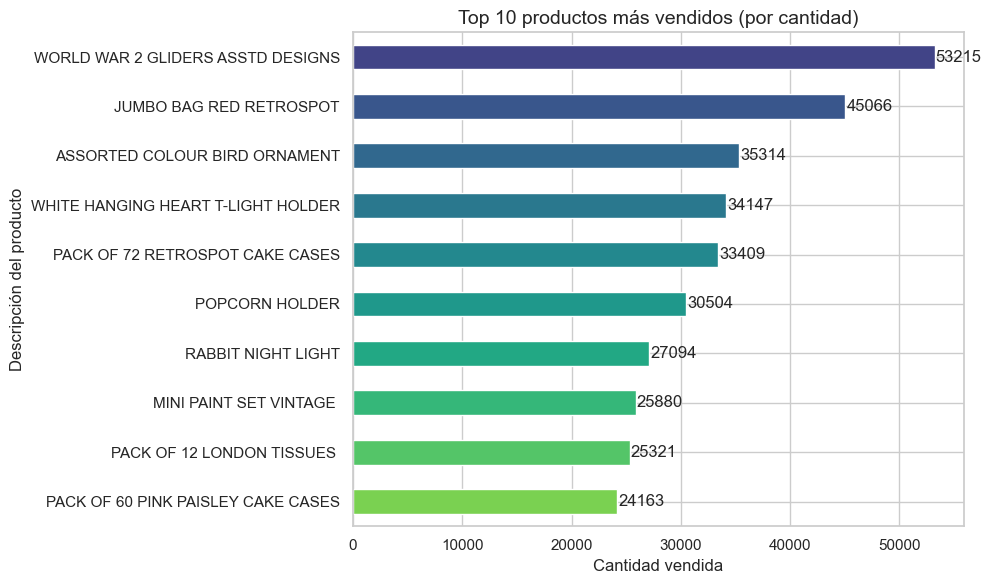

In [33]:
import matplotlib.pyplot as plt

# Agrupar por descripción del producto y sumar cantidades
top_products = df.groupby('Description')['Quantity'].sum()

# Ordenar de mayor a menor y quedarnos con los 10 más vendidos
top_products = top_products.sort_values(ascending=False).head(10)

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar con barras horizontales, usando un colormap más amigable
top_products.plot(kind='barh', ax=ax, color=plt.cm.viridis(np.linspace(0.2, 0.8, 10)))

# Agregar etiquetas numéricas al final de cada barra
for i, value in enumerate(top_products):
    ax.text(value + 100, i, str(int(value)), va='center')

# Invertir eje Y para que el producto más vendido esté arriba
ax.invert_yaxis()

# Títulos y etiquetas
ax.set_title('Top 10 productos más vendidos (por cantidad)', fontsize=14)
ax.set_xlabel('Cantidad vendida')
ax.set_ylabel('Descripción del producto')

# Ajustar márgenes
plt.tight_layout()
plt.show()

### Top Clientes

C:\Users\USER\AppData\Local\Temp\ipykernel_11672\673157047.py:34: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


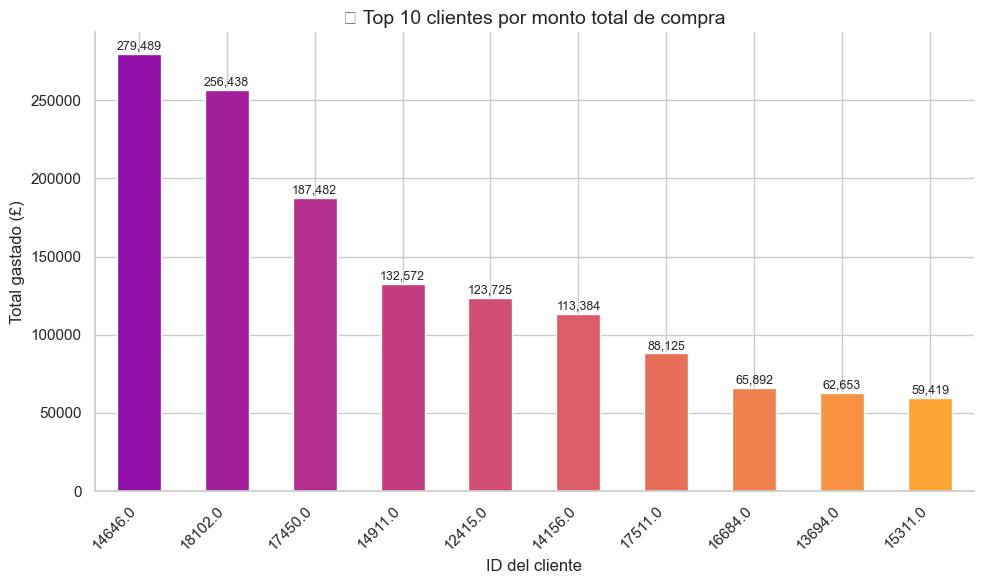

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Crear una nueva columna que representa el valor total por línea de producto
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Agrupar por CustomerID y sumar TotalPrice para obtener el gasto total por cliente
top_customers = df.groupby('CustomerID')['TotalPrice'].sum()

# Ordenar y seleccionar los 10 mejores clientes por gasto total
top_customers = top_customers.sort_values(ascending=False).head(10)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar en barras con colores personalizados
top_customers.plot(kind='bar', ax=ax, color=plt.cm.plasma(np.linspace(0.3, 0.8, 10)))

# Agregar valores numéricos encima de cada barra
for idx, value in enumerate(top_customers):
    ax.text(idx, value + 3000, f'{int(value):,}', ha='center', fontsize=9)

# Títulos y etiquetas
ax.set_title('💰 Top 10 clientes por monto total de compra', fontsize=14)
ax.set_ylabel('Total gastado (£)')
ax.set_xlabel('ID del cliente')

# Mejora visual del eje X
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Quitar bordes innecesarios y ajustar layout
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


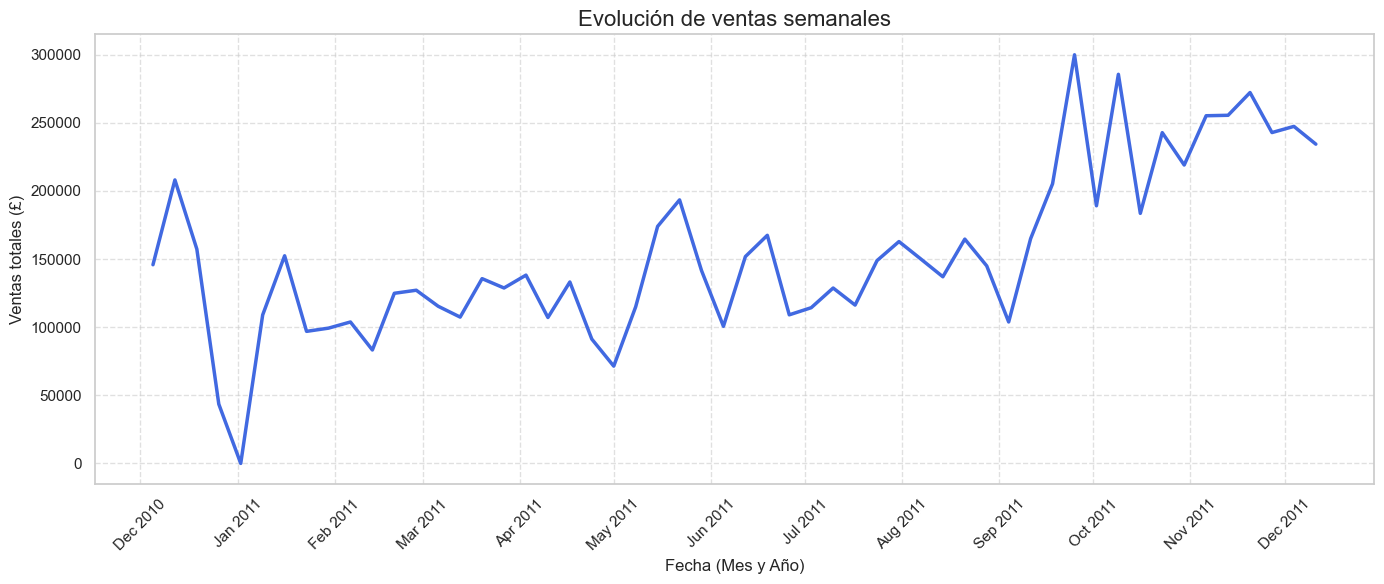

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Asegurarse de que las fechas estén en formato datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calcular el monto total por transacción
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Agrupar ventas por semana
weekly_sales = df.set_index('InvoiceDate')['TotalPrice'].resample('W').sum()

# Crear la figura
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_sales, color='royalblue', linewidth=2.5)

# Formato del eje X con meses y años
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Ejemplo: Ene 2011
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Mostrar cada mes

# Estética del gráfico
plt.title('Evolución de ventas semanales', fontsize=16)
plt.xlabel('Fecha (Mes y Año)', fontsize=12)
plt.ylabel('Ventas totales (£)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Rotar etiquetas del eje X para mayor legibilidad
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Chequear Outliers

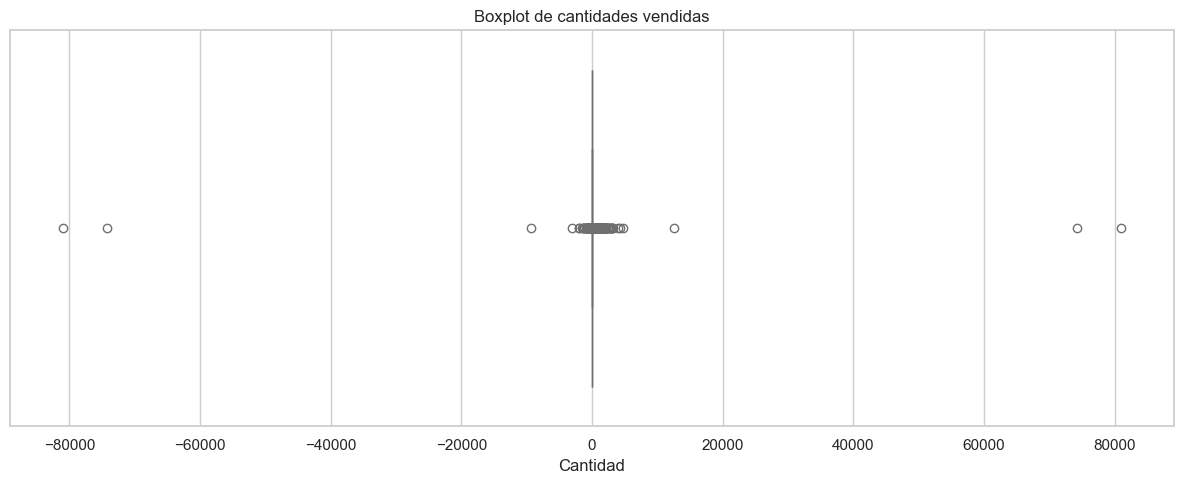

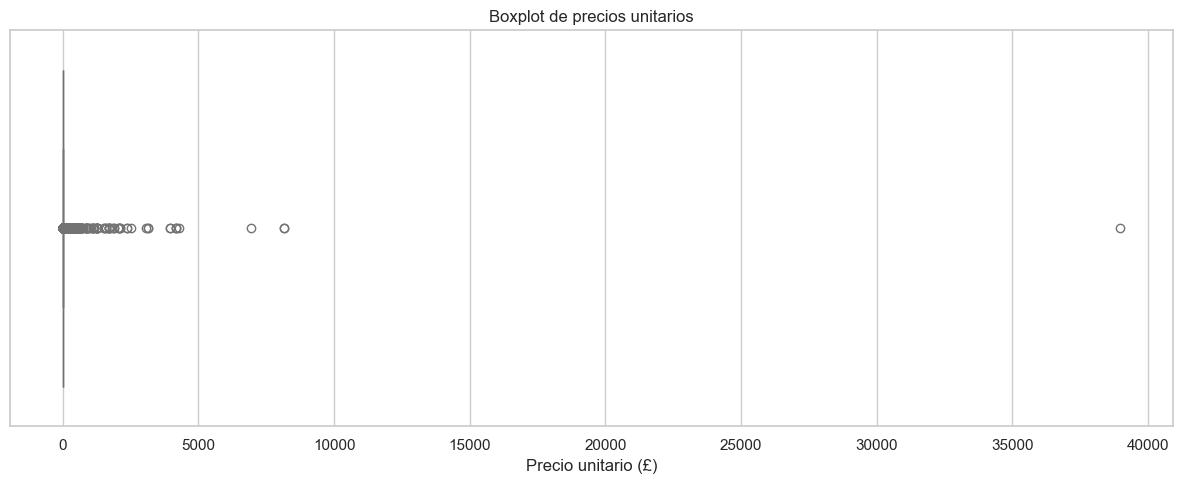

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer estilo visual de Seaborn para mejor apariencia
sns.set(style="whitegrid")

# -------------------------------
# Boxplot para la variable 'Quantity'
# Este gráfico nos permite ver la distribución y detectar valores atípicos (outliers) en las cantidades vendidas.
# -------------------------------
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['Quantity'], color='skyblue')
plt.title('Boxplot de cantidades vendidas')
plt.xlabel('Cantidad')
plt.tight_layout()
plt.show()

# -------------------------------
# Boxplot para la variable 'UnitPrice'
# Aquí identificamos precios unitarios fuera de lo común que podrían representar errores o productos premium.
# -------------------------------
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['UnitPrice'], color='lightgreen')
plt.title('Boxplot de precios unitarios')
plt.xlabel('Precio unitario (£)')
plt.tight_layout()
plt.show()


Tratamiento de outliers

In [37]:

# Definir los percentiles para identificar outliers
# Se eliminan los valores fuera del rango del 2.5% al 97.5% para las variables 'Quantity' y 'UnitPrice'


# Percentiles para 'Quantity'
q_low = df['Quantity'].quantile(0.025)
q_high = df['Quantity'].quantile(0.975)

# Percentiles para 'UnitPrice'
p_low = df['UnitPrice'].quantile(0.025)
p_high = df['UnitPrice'].quantile(0.975)


# Filtrar valores fuera del rango aceptado (outliers)
# Se conservan solo los registros cuyas cantidades y precios estén dentro del rango intercuartílico

df = df[(df['Quantity'] >= q_low) & (df['Quantity'] <= q_high)]
df = df[(df['UnitPrice'] >= p_low) & (df['UnitPrice'] <= p_high)]


### RFM

In [38]:
import datetime as dt


# Establecer una fecha de referencia (snapshot)
# Es la fecha más reciente en el dataset + 1 día para el cálculo de recency

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)


# Agrupar por cliente para calcular métricas RFM:
# - Recency: días desde la última compra
# - Frequency: cantidad de compras (facturas únicas)
# - Monetary: monto total gastado por cliente
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
})

# Renombrar columnas a las etiquetas RFM clásicas
rfm.columns = ['Recency', 'Frequency', 'Monetary']


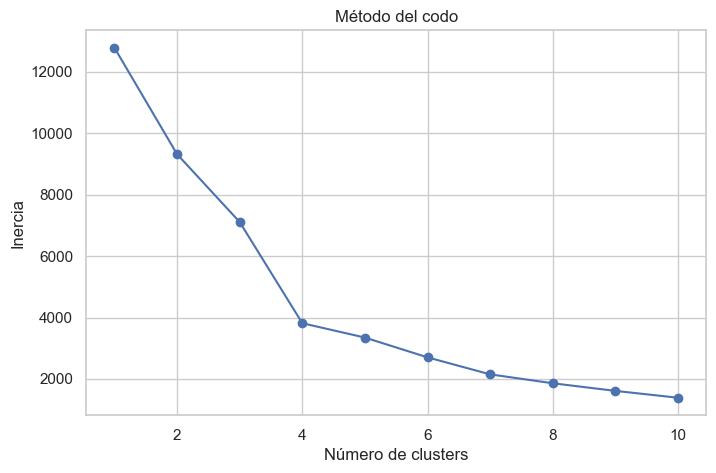

In [47]:
# Importar librerías necesarias
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd


# 1. Normalización de las variables RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# 2. (Opcional) Reducción de dimensionalidad con PCA para visualización
pca = PCA(n_components=2)
pca_rfm = pca.fit_transform(rfm_scaled)  # útil si luego quieres visualizar los clusters

# 3. Convertir a DataFrame el resultado escalado (conservar nombres de columnas e índices)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

# 4. Método del codo para determinar el número óptimo de clusters
inertia = []  # Lista para almacenar la inercia de cada modelo
K = range(1, 11)  # Probar de 1 a 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)  # Guardar la inercia (error cuadrático intra-cluster)

# 5. Visualizar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.grid(True)
plt.show()



El gráfico muestra una disminución pronunciada de la inercia hasta el valor de 4 clusters, donde la curva comienza a estabilizarse. Este "codo" sugiere que 4 es el número óptimo de clusters para segmentar a los clientes de manera eficiente sin sobreajustar el modelo.



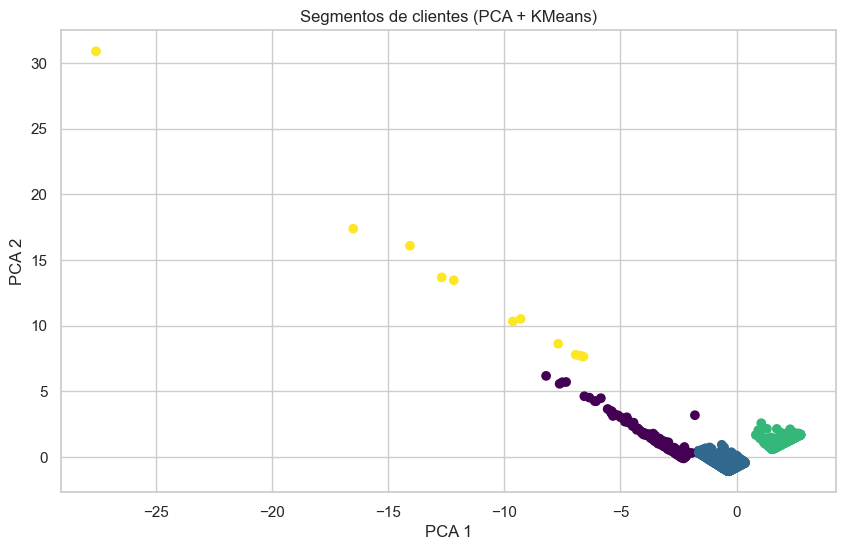

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Escalamos los datos
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Aplicamos PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
pca_rfm = pca.fit_transform(rfm_scaled)

# 4. KMEANS (con k=4)

# Aplicamos KMeans con 4 clusters (obtenido por método del codo)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)

# Añadimos etiquetas al DataFrame original RFM
rfm['Cluster'] = clusters


# 5. VISUALIZACIÓN DE CLUSTERS

plt.figure(figsize=(10, 6))
plt.scatter(
    pca_rfm[:, 0],             # Componente principal 1
    pca_rfm[:, 1],             # Componente principal 2
    c=clusters,                # Color según cluster
    cmap='viridis'             # Paleta de color
)
plt.title('Segmentos de clientes (PCA + KMeans)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

El análisis mediante PCA y K-Means permitió identificar 4 segmentos de clientes claramente diferenciados. Esta segmentación ayuda a personalizar estrategias de marketing, fidelización y optimización de recursos según el comportamiento de compra de cada grupo.

In [57]:
# Calcular la puntuación promedio del coeficiente de silueta para evaluar qué tan buenos son los clusters
silhouette_avg = silhouette_score(X, clusters)
print(f"Silhouette Score: {silhouette_avg:.2f}")
# Un valor cercano a 1 indica que los clusters están bien definidos; valores >0.5 suelen considerarse buenos


Silhouette Score: 0.59


In [58]:
# Agrupar los clientes por cluster y calcular los promedios de Recency, Frequency y Monetary
# Esto ayuda a interpretar el perfil de cada grupo
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)


,Recency,Frequency,Monetary
Cluster,,,
0,13.08,20.64,7955.86
1,43.49,3.60,1122.89
2,247.57,1.54,400.94
3,4.18,82.64,51042.48


In [59]:
# Ver cuántos clientes hay en cada cluster (distribución)
# Permite detectar desbalance y evaluar si hay grupos poco representativos
rfm['Cluster'].value_counts().sort_index()

Cluster
0     212
1    2983
2    1056
3      11
Name: count, dtype: int64

In [63]:
# Importamos la métrica Davies-Bouldin desde sklearn
from sklearn.metrics import davies_bouldin_score

# Calculamos el índice DBI usando los datos escalados (X) y las etiquetas de cluster obtenidas
db_index = davies_bouldin_score(X, clusters)

# Mostramos el resultado con 2 decimales
print(f"Davies-Bouldin Index: {db_index:.2f}")


Davies-Bouldin Index: 0.67


El Davies-Bouldin Index (DBI) es una métrica de evaluación interna del clustering que cuantifica:

Qué tan compactos son los clusters (baja dispersión interna).

Qué tan separados están entre sí (alta distancia inter-cluster).

In [65]:
# Importamos la métrica desde sklearn
from sklearn.metrics import calinski_harabasz_score

# Calculamos el índice Calinski-Harabasz usando los datos escalados (X) y las etiquetas de cluster
ch_score = calinski_harabasz_score(X, clusters)

# Mostramos el resultado con 2 decimales
print(f"Calinski-Harabasz Score: {ch_score:.2f}")



Calinski-Harabasz Score: 3319.55


El Calinski-Harabasz Score obtuvo un valor de 3319.55, lo cual indica una excelente separación entre los grupos generados por K-Means. Este resultado complementa al Silhouette Score (0.59) y al Davies-Bouldin Index (0.67), aportando mayor robustez a la evaluación del clustering.

C:\Users\USER\AppData\Local\Temp\ipykernel_11672\3202232264.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
C:\Users\USER\AppData\Local\Temp\ipykernel_11672\3202232264.py:13: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
C:\Users\USER\AppData\Local\Temp\ipykernel_11672\3202232264.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
C:\Users\USER\AppData\Local\Temp\ipykernel_11672\32022

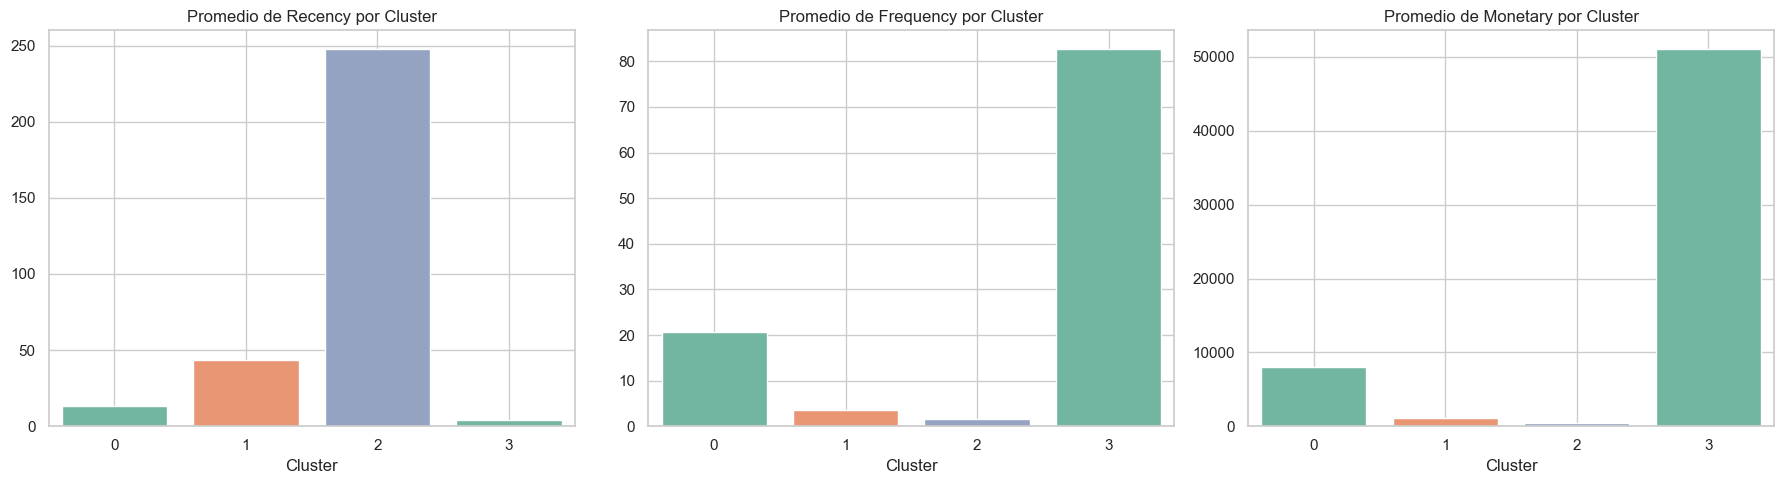

In [68]:
# Agrupamos los datos por cluster y calculamos el promedio de las variables RFM
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Creamos una figura con 3 subplots horizontales (1 fila, 3 columnas)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Definimos las variables y los colores para cada gráfico
variables = ['Recency', 'Frequency', 'Monetary']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']  # Colores para cada barplot

# Generamos un barplot para cada variable
for i, var in enumerate(variables):
    sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
    axes[i].set_title(f'Promedio de {var} por Cluster')
    axes[i].set_ylabel('')
    axes[i].set_xlabel('Cluster')
    axes[i].grid(True)

# Ajustamos el diseño para evitar que los elementos se encimen
plt.tight_layout()
plt.show()



# Construccion de Modelos

### XGBoost Regresion sobre AOV

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Selección de variables
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

# Escalar variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modelo XGBoost para regresión
xgb_regressor = xgb.XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_regressor.predict(X_test)

# Evaluación del modelo
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_xgb))
print("R^2 Score:", r2_score(y_test, y_pred_xgb))


XGBoostRegressor
Mean Squared Error: 11506885.274521163
R^2 Score: -0.15214768220096042


El valor negativo de R² indica que el modelo no fue capaz de ajustar adecuadamente los datos, es decir, sus predicciones fueron peores que simplemente usar la media del valor objetivo. Esto puede deberse a:

La relación entre Recency, Frequency y Monetary no es lineal o no es fuerte.

El conjunto de datos puede contener outliers o ruido que afecta el aprendizaje.

Se requiere ingeniería de variables adicional o incorporar otras variables relevante

In [70]:
from sklearn.ensemble import RandomForestRegressor

# Modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluación del modelo
print("\nRandomForestRegressor")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_rf))
print("R^2 Score:", r2_score(y_test, y_pred_rf))



RandomForestRegressor
Mean Squared Error: 7946894.323112237
R^2 Score: 0.20430284506762464


El modelo de Random Forest superó al modelo de XGBoost, el cual había obtenido un R² negativo.

Aunque el R² de 0.20 indica un ajuste modesto, muestra una mejora considerable respecto al modelo anterior.

Random Forest logra capturar mejor la variabilidad del Monetary en relación con las otras variables del análisis RFM.

In [71]:
from sklearn.linear_model import LinearRegression

# Modelo lineal base
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test)

# Evaluación
print("\nLinearRegression")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_lr))
print("R^2 Score:", r2_score(y_test, y_pred_lr))



LinearRegression
Mean Squared Error: 7446485.488699463
R^2 Score: 0.2544071839018843


Aunque se trata de un modelo lineal simple, superó tanto a XGBoost como a Random Forest en términos de R², alcanzando un 25.44% de varianza explicada.

Esto sugiere que las relaciones entre las variables Recency y Frequency con Monetary pueden ser bastante lineales.

# Validacion

### ✅ Validación de Modelos

Para validar el rendimiento de los modelos aplicados sobre el AOV (`Monetary`), se compararon tres algoritmos: **XGBoost**, **Random Forest** y **Regresión Lineal**. Se utilizaron dos métricas:

- **MSE (Mean Squared Error)**: Error cuadrático medio.
- **R² Score**: Proporción de la varianza explicada por el modelo.

| Modelo           | MSE          | R² Score |
|------------------|--------------|----------|
| Regresión Lineal | 7,446,485.49 | **0.2544** |
| Random Forest    | 7,946,894.32 | 0.2043   |
| XGBoost          | 11,506,885.27| -0.15    |

**Conclusión:**  
El modelo más simple, la **regresión lineal**, obtuvo el mejor R² Score, lo que sugiere una relación lineal entre `Recency`, `Frequency` y el AOV. Los modelos complejos no necesariamente mejoraron la predicción.


# Propuesta

### 💡 Propuesta de Mejora

A partir del análisis realizado, se sugieren las siguientes acciones para mejorar los resultados y el valor del análisis RFM:

1. **Agregar nuevas variables al modelo**:
   - Incorporar `CustomerID`, `Country`, o `Product Category` para enriquecer la predicción del valor monetario.
   - Usar `Recency` y `Frequency` como tiempo continuo en lugar de binarizaciones.

2. **Ajustar el objetivo**:
   - En lugar de predecir `Monetary` como una regresión pura, se podría usar clasificación de clientes en rangos de gasto (`bajo`, `medio`, `alto`).

3. **Optimización de hiperparámetros**:
   - Aplicar `GridSearchCV` o `RandomizedSearchCV` para encontrar los parámetros ideales en Random Forest o XGBoost.

4. **Segmentación + Predicción**:
   - Combinar la segmentación por clustering con modelos de predicción para ofrecer campañas personalizadas a cada grupo.

5. **Validación cruzada (cross-validation)**:
   - Aumentar la robustez del modelo implementando `KFold` para evaluar la estabilidad de las métricas.



# Reflexion

### Reflexión

Este ejercicio demostró que **la simplicidad en modelos puede ser más efectiva** cuando los datos no justifican una complejidad mayor. Aunque XGBoost y Random Forest son potentes, en este caso no superaron a la regresión lineal debido a la naturaleza lineal del problema.

Se evidenció la importancia de:

- Validar con métricas objetivas y múltiples modelos.
- No asumir que modelos complejos entregan mejores resultados.
- Aplicar visualizaciones y clustering (RFM) como base para acciones más estratégicas.

**Aprendizaje clave:**  
A veces, conocer profundamente los datos y elegir el modelo correcto es más valioso que aplicar técnicas avanzadas sin análisis previo.
